# Example notebook for analysis of patch-probe microarray data

To accompany the paper &ldquo;Measuring intramolecular connectivity in long RNA molecules using two-dimensional DNA patch-probe arrays,&rdquo; by Timothy K. Chiang, Ofer Kimchi, Herman K. Dhaliwal, Daniel A. Villarreal, Fernando F. Vasquez, Vinothan N. Manoharan, Michael P. Brenner, and Rees F. Garmann, _Nucleic Acids Research_ 2025.

Copyright 2022, 2023, 2025 Vinothan N. Manoharan <vnm@seas.harvard.edu>

This program is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <https://www.gnu.org/licenses/>.

This notebook demonstrates the Bayesian approach to inferring the signal and prevalence from patch-probe microarray data.  It relies on the `patchprobe` package, which should be placed inside the working directory of the notebook.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import pymc as pm
import aesara
import aesara.tensor as at
import arviz as az

# for selecting random samples
from numpy.random import default_rng
rng = default_rng()

from scipy.stats import norm, pearsonr

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import proplot as pplt
#Set defaults for plotting with ProPlot
pplt.config.rc.load("proplotrc")

# The patchprobe package must be in a subdirectory
# of the working directory for this notebook to work
import patchprobe as pp

Versions of packages used in this notebook are shown below. To reproduce the results in the paper ), ensure that these packages and versions are installed.

In [2]:
# from https://stackoverflow.com/a/63989321
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.23.3
pandas==1.5.0
xarray==2022.9.0
pymc==4.2.1
aesara==2.8.6
arviz==0.12.1
matplotlib==3.4.3
seaborn==0.12.0
proplot==0.9.5


## Fixed parameters and constants

These parameters need to be set appropriately to replicate the analysis results shown in this notebook.

### Path to data

The following line specifies the path to the data (feature extraction files, raw scan files, and inference data files).  The data can be downloaded from https://doi.org/10.7910/DVN/83HMGQ. Please update the path below to reflect the path to the data. The rest of this notebook assumes that the data are organized into the same folders as in the data repository.

In [3]:
# Set this to the root of the data repository.  Can also use
# an absolute path such as 
# data_dir = Path('/home/user/data')
data_dir = Path.cwd() / Path('data')

The following paths should not have to be changed if the `data_dir` is set correctly.

In [4]:
# path to datasets stored in netCDF format
dataset_path = data_dir / Path('5_Datasets')

# store inference data (samples from MCMC runs) in the current working directory.
# These files can be quite large (1 GB or more).
idata_path = Path.cwd()

# path to store summary statistics files from MCMC runs.  These files
# are much smaller than the InferenceData files containing samples,
# because they only contain summary statistics (mean, std dev, etc) of 
# the marginalized posterior for each parameter.
summary_path = data_dir / Path('4_Inference_Data')

### Cache directory

This directory is used only for caching test results, so that if the notebook is re-run, the MCMC samples for the test results can be loaded from disk.  The directory will likely have to be created.  

In [5]:
cache_dir = Path.cwd() / Path('cache')

### MCMC sampling parameters

Default is to use four chains for MCMC sampling, which will work fine on a machine with at least 2 cores and 2 threads/core.  Increasing this value will not make things run faster, but will generate more samples for each MCMC run.

In [6]:
CHAINS = 4

The `jitter+adapt_diag_grad` MCMC initialization method seems to offer the fastest tuning for our model and for pymc version 4.

In [7]:
INIT ='jitter+adapt_diag_grad'

The following parameters will be sent to `pm.sample()` for the analysis of the `signal` model:

In [8]:
signal_kwargs = {'tune' : 1000, 
                 'draws' : 500, 
                 'init' : INIT, 
                 'chains' : CHAINS}

It takes more computational effort to infer the parameters of the `fraction` model, so we reduce the number of tuning steps and draws in this case:

In [9]:
fraction_kwargs = {'tune' : 500, 
                  'draws' : 200, 
                  'init' : INIT, 
                  'chains' : CHAINS}

## Read in the data

We use Python to read the data into `xarray` `Dataset` objects that contain both metadata (such as probe size, patch size, feature extraction software, and directory in which the comma-separated value files were stored) and data for each microarray.  We use a separate `Dataset` for each probe size, so that data on a single microarray is split up into two `Dataset`s, one corresponding to 12-base-long probes and one to 24-base-long probes.  We read in all the datasets at once and store them in a dictionary, keyed by a short-form identifier for each dataset.

In [10]:
datasets = pp.read_datasets(dataset_path)

Within each `Dataset`, we separate the measurements into patch-probe measurements and background measurements (which correspond to wells containing unpatched RNA).  The patch-probe measurements are stored in `xarray DataArray` objects which contain integrated fluorescence measurements for each spot, patch, and probe.  The number of values in the `spot` coordinate corresponds to the maximum number of spots for any patch-probe combination. We use `NaN` values to pad the data. For example, here are the integrated fluorescence measurements for patch 1, probes 1-7:

In [11]:
datasets['sdsu12'].patchprobe.sel(patch=1, probe=slice(1,7))

<xarray.DataArray 'patchprobe' (spot: 12, probe: 7)>
array([[44.2526, 49.967 , 30.7113, 40.5155, 43.697 , 36.75  , 48.2065],
       [30.3163, 37.1979, 34.8557, 31.0515, 36.2316, 32.2347, 45.8947],
       [31.3913, 31.2418, 29.9895, 32.9053, 37.6354, 36.5979, 34.3196],
       [32.36  , 28.4792, 32.1856, 27.01  , 54.0947,     nan, 34.4184],
       [    nan, 27.4632, 37.4583, 21.3333, 40.9896,     nan, 44.2577],
       [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
       [    nan,     nan,     nan,     nan,     nan,     nan,     nan]])
Coordinates:
  * probe    (probe) int64 1 2 3 4 5 6 7
  * spot     (spot) int64 0 1 2 3 4 5 6 7 8 9 10 11
    patch    int64 1

Reading down the columns, we can see that probe 1 has measurements at 4 spots, probe 2 at 5 spots, and so on.

We also use a `DataArray` to store measurements on unpatched RNA.  The integrated fluorescence measurements are stored for each spot, probe, and &ldquo;repeat&rdquo;, where each repeat corresponds to a background measurement made in a different well. For example, here are all the repeat measurements for probe 1:

In [12]:
datasets['sdsu12'].background.sel(probe=1)

<xarray.DataArray 'background' (spot: 12, repeat: 4)>
array([[ 63.7447,  46.8454,  86.5758, 111.102 ],
       [ 54.0202,  63.0306,  51.2917,  89.8854],
       [ 56.5979,  48.2526,  66.6939, 122.25  ],
       [ 84.5638,      nan,      nan,  91.5155],
       [     nan,      nan,      nan,      nan],
       [     nan,      nan,      nan,      nan],
       [     nan,      nan,      nan,      nan],
       [     nan,      nan,      nan,      nan],
       [     nan,      nan,      nan,      nan],
       [     nan,      nan,      nan,      nan],
       [     nan,      nan,      nan,      nan],
       [     nan,      nan,      nan,      nan]])
Coordinates:
  * repeat   (repeat) int64 1 2 3 4
    probe    int64 1
  * spot     (spot) int64 0 1 2 3 4 5 6 7 8 9 10 11

Here each column corresponds to a different well.

## Test of signal model: decimated 12-base dataset

This section shows a test of the MCMC approach using a decimated data set.  This code is useful for checking whether the sampler is working, since it only takes a couple of minutes to analyze the decimated data. 

The following function sets the background scaling parameter.

In [13]:
def set_background_scale(dataset):
    """
    Sets background scale depending on how feature extraction is done. 
    The background scale is a characteristic scale for an individual 
    measurement of probe binding to the RNA.  It depends on the probe 
    size and the feature extraction method.
    """
    if 'agilent' in dataset.processing_method:
        background_scale = 100
    else:
        background_scale = 1e7
    # 24-base probes have 10-fold higher scale 
    if dataset.probe_size == 24:
        background_scale = background_scale * 10
    return background_scale

Analyzing decimated data allows us to see how outliers affect the results, without us having to analyze the full data set.

In [14]:
key = 'sdsu12'
# decimate so that only every 12th probe remains
decimated = datasets[key].sel(probe=slice(1, None, 12)).copy()
# update short ID so that we can save inference data to cache with unique filename
decimated.attrs['shortID'] = key + "decimated"

First we'll look at the non-robust (normal likelihood) model.  The code below runs the MCMC sampler on the decimated data set.  If a cached version of the inference data is available, it loads it from disk instead of re-sampling.  To force re-sampling, delete the cached file.

In [15]:
model = pp.PatchprobeModel(decimated, background_scale=set_background_scale(decimated), model_type='signal', robust=False)
idata, summary_stats = model.sample(idata_path = cache_dir, summary_path = cache_dir, tune=500, draws=200, init=INIT, chains=CHAINS)

Loading existing inference data file: cache/sdsu12decimated_STMV_12_24_annealed_SG15294487_258644410004_S001_agilent-signal-gaussian-idata.nc
Original sampling time was 0:01:16.486475
Loading existing summary file: cache/sdsu12decimated_STMV_12_24_annealed_SG15294487_258644410004_S001_agilent-signal-gaussian-summary.nc


Inferred signal:

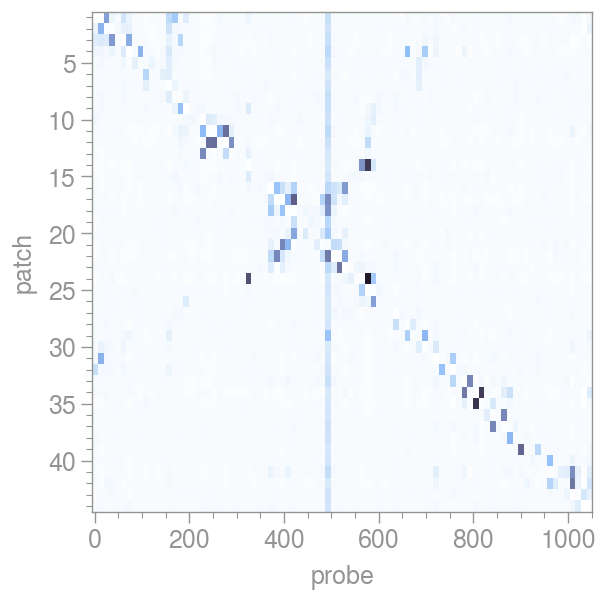

In [16]:
fig, ax = pplt.subplots()
ax.pcolormesh(summary_stats.S.sel(metric='mean').T, cmap='dusk')
ax.format(yreverse=True)

Note the streak across the signal map at probe 493 and the high value of the median for this probe shown in the bottom middle plot. The streak arises because the inferred background is underestimated. If we look at the raw data, we see that the underestimate appears to be due to an anomalously small measurement for the background (40, compared to a mean of about 1000 for the other replicates):

In [17]:
decimated.background.sel(probe=493)

<xarray.DataArray 'background' (spot: 12, repeat: 4)>
array([[ 856.3804,  837.8646,  938.6633, 1201.466 ],
       [ 950.39  ,  993.875 , 1038.827 , 1148.232 ],
       [ 866.6939,  819.9053,  995.1505, 1152.347 ],
       [ 888.1111,  686.3226,  940.3021, 1158.28  ],
       [ 879.6837,  709.2   , 1005.109 , 1033.529 ],
       [ 898.3636,  726.9495,  993.0505, 1084.703 ],
       [ 936.47  ,       nan,  983.7396, 1161.594 ],
       [ 931.5313,       nan,  986.0404, 1131.745 ],
       [      nan,       nan,   40.4898,       nan],
       [      nan,       nan,  782.1837,       nan],
       [      nan,       nan,       nan,       nan],
       [      nan,       nan,       nan,       nan]])
Coordinates:
  * repeat   (repeat) int64 1 2 3 4
    probe    int64 493
  * spot     (spot) int64 0 1 2 3 4 5 6 7 8 9 10 11

The one anomalously small replicate (40.4898) shifts the mean of inferred background under the normal likelihood.  The problem is that a normal likelihood is not a good model for the data. To handle outliers like this without having to decide what values are outliers, we use a robust inference model based on the Student-T likelihood, with a prior on the degrees of freedom.  Here are the results from that approach.

In [18]:
model = pp.PatchprobeModel(decimated, background_scale=set_background_scale(decimated), model_type='signal')
idata, summary_stats = model.sample(idata_path = cache_dir, summary_path = cache_dir, tune=500, draws=200, init=INIT, chains=CHAINS)

Loading existing inference data file: cache/sdsu12decimated_STMV_12_24_annealed_SG15294487_258644410004_S001_agilent-signal-idata.nc
Original sampling time was 0:02:27.557837
Loading existing summary file: cache/sdsu12decimated_STMV_12_24_annealed_SG15294487_258644410004_S001_agilent-signal-summary.nc


Inferred signal:

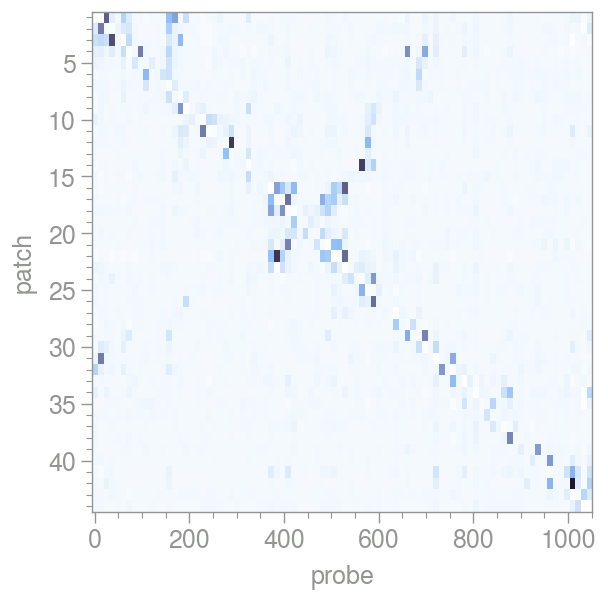

In [19]:
fig, ax = pplt.subplots()
ax.pcolormesh(summary_stats.S.sel(metric='mean').T, cmap='dusk')
ax.format(yreverse=True)

Now we see that the streak is gone and no patches or probes seem to have a large median value.

Below are summary statistics for the hyperparameters in the model:

In [20]:
with model:
    display(az.summary(idata, var_names=['sigma', 'mu_c', 'sigma_c', 'nu_obs', 'nu_obs_B'])) 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.119,0.001,0.116,0.121,0.000,0.000,325.0,463.0,1.01
mu_c,1.047,0.017,1.016,1.079,0.002,0.002,48.0,225.0,1.06
sigma_c,0.103,0.013,0.081,0.129,0.001,0.001,146.0,385.0,1.01
nu_obs,3.466,0.113,3.264,3.680,0.006,0.004,357.0,481.0,1.02
nu_obs_B,4.311,0.364,3.654,5.022,0.013,0.009,793.0,654.0,1.00


The estimate of standard deviation in concentration scalings is 10%, about what we expect for pipetting error.  The inferred Student-T degrees of freedom are also given (note that $\nu\to\infty$ corresponds to a normal distribution and $\nu=1$ to a Cauchy distribution).

## Inference of signals from all data sets

The following function will run the sampler on all the (complete) patch-probe data sets.  If output files exist for any data set, it will load the output file rather than re-sampling.  To force re-sampling, delete or rename the existing output file.  Note that sampling all the data sets will take many hours.

In [21]:
for dataset in datasets.values():
    print(dataset.description)
    
    # make model
    model = pp.PatchprobeModel(dataset, background_scale=set_background_scale(dataset), model_type='signal')
    # sample from it and save results
    _, _ = model.sample(idata_path = idata_path, summary_path = summary_path, **signal_kwargs)

STMV 12-nt probes
Loading existing inference data file: sdsu12_STMV_12_24_annealed_SG15294487_258644410004_S001_agilent-signal-idata.nc
Original sampling time was 7:08:55.259733
Loading existing summary file: data/InferenceData/sdsu12_STMV_12_24_annealed_SG15294487_258644410004_S001_agilent-signal-summary.nc
STMV 24-nt probes
Loading existing inference data file: sdsu24_STMV_24_24_annealed_SG15294487_258644410004_S001_agilent-signal-idata.nc
Original sampling time was 5:15:47.095738
Loading existing summary file: data/InferenceData/sdsu24_STMV_24_24_annealed_SG15294487_258644410004_S001_agilent-signal-summary.nc
STMV 12-nt probes; patches not annealed
Loading existing inference data file: sdsu12unannealed_STMV_12_24_unannealed_SG15294487_258644410002_20220920123447_S001_agilent-signal-idata.nc
Original sampling time was 7:37:52.444403
Loading existing summary file: data/InferenceData/sdsu12unannealed_STMV_12_24_unannealed_SG15294487_258644410002_20220920123447_S001_agilent-signal-summa

## Example of signal results from STMV RNA 12-nt probe data set

Functions from the `patchprobe` library can be used to find sampling results for a specific data set and plot the results.  For example, to find and load the results for the 12-nt probe data set for STMV RNA, we use

In [22]:
summary_file = pp.find_summaries(datasets['sdsu12'], summary_path, model_type='signal')
summary_stats = xr.open_dataset(summary_file[0])

Plot the posterior and other information:

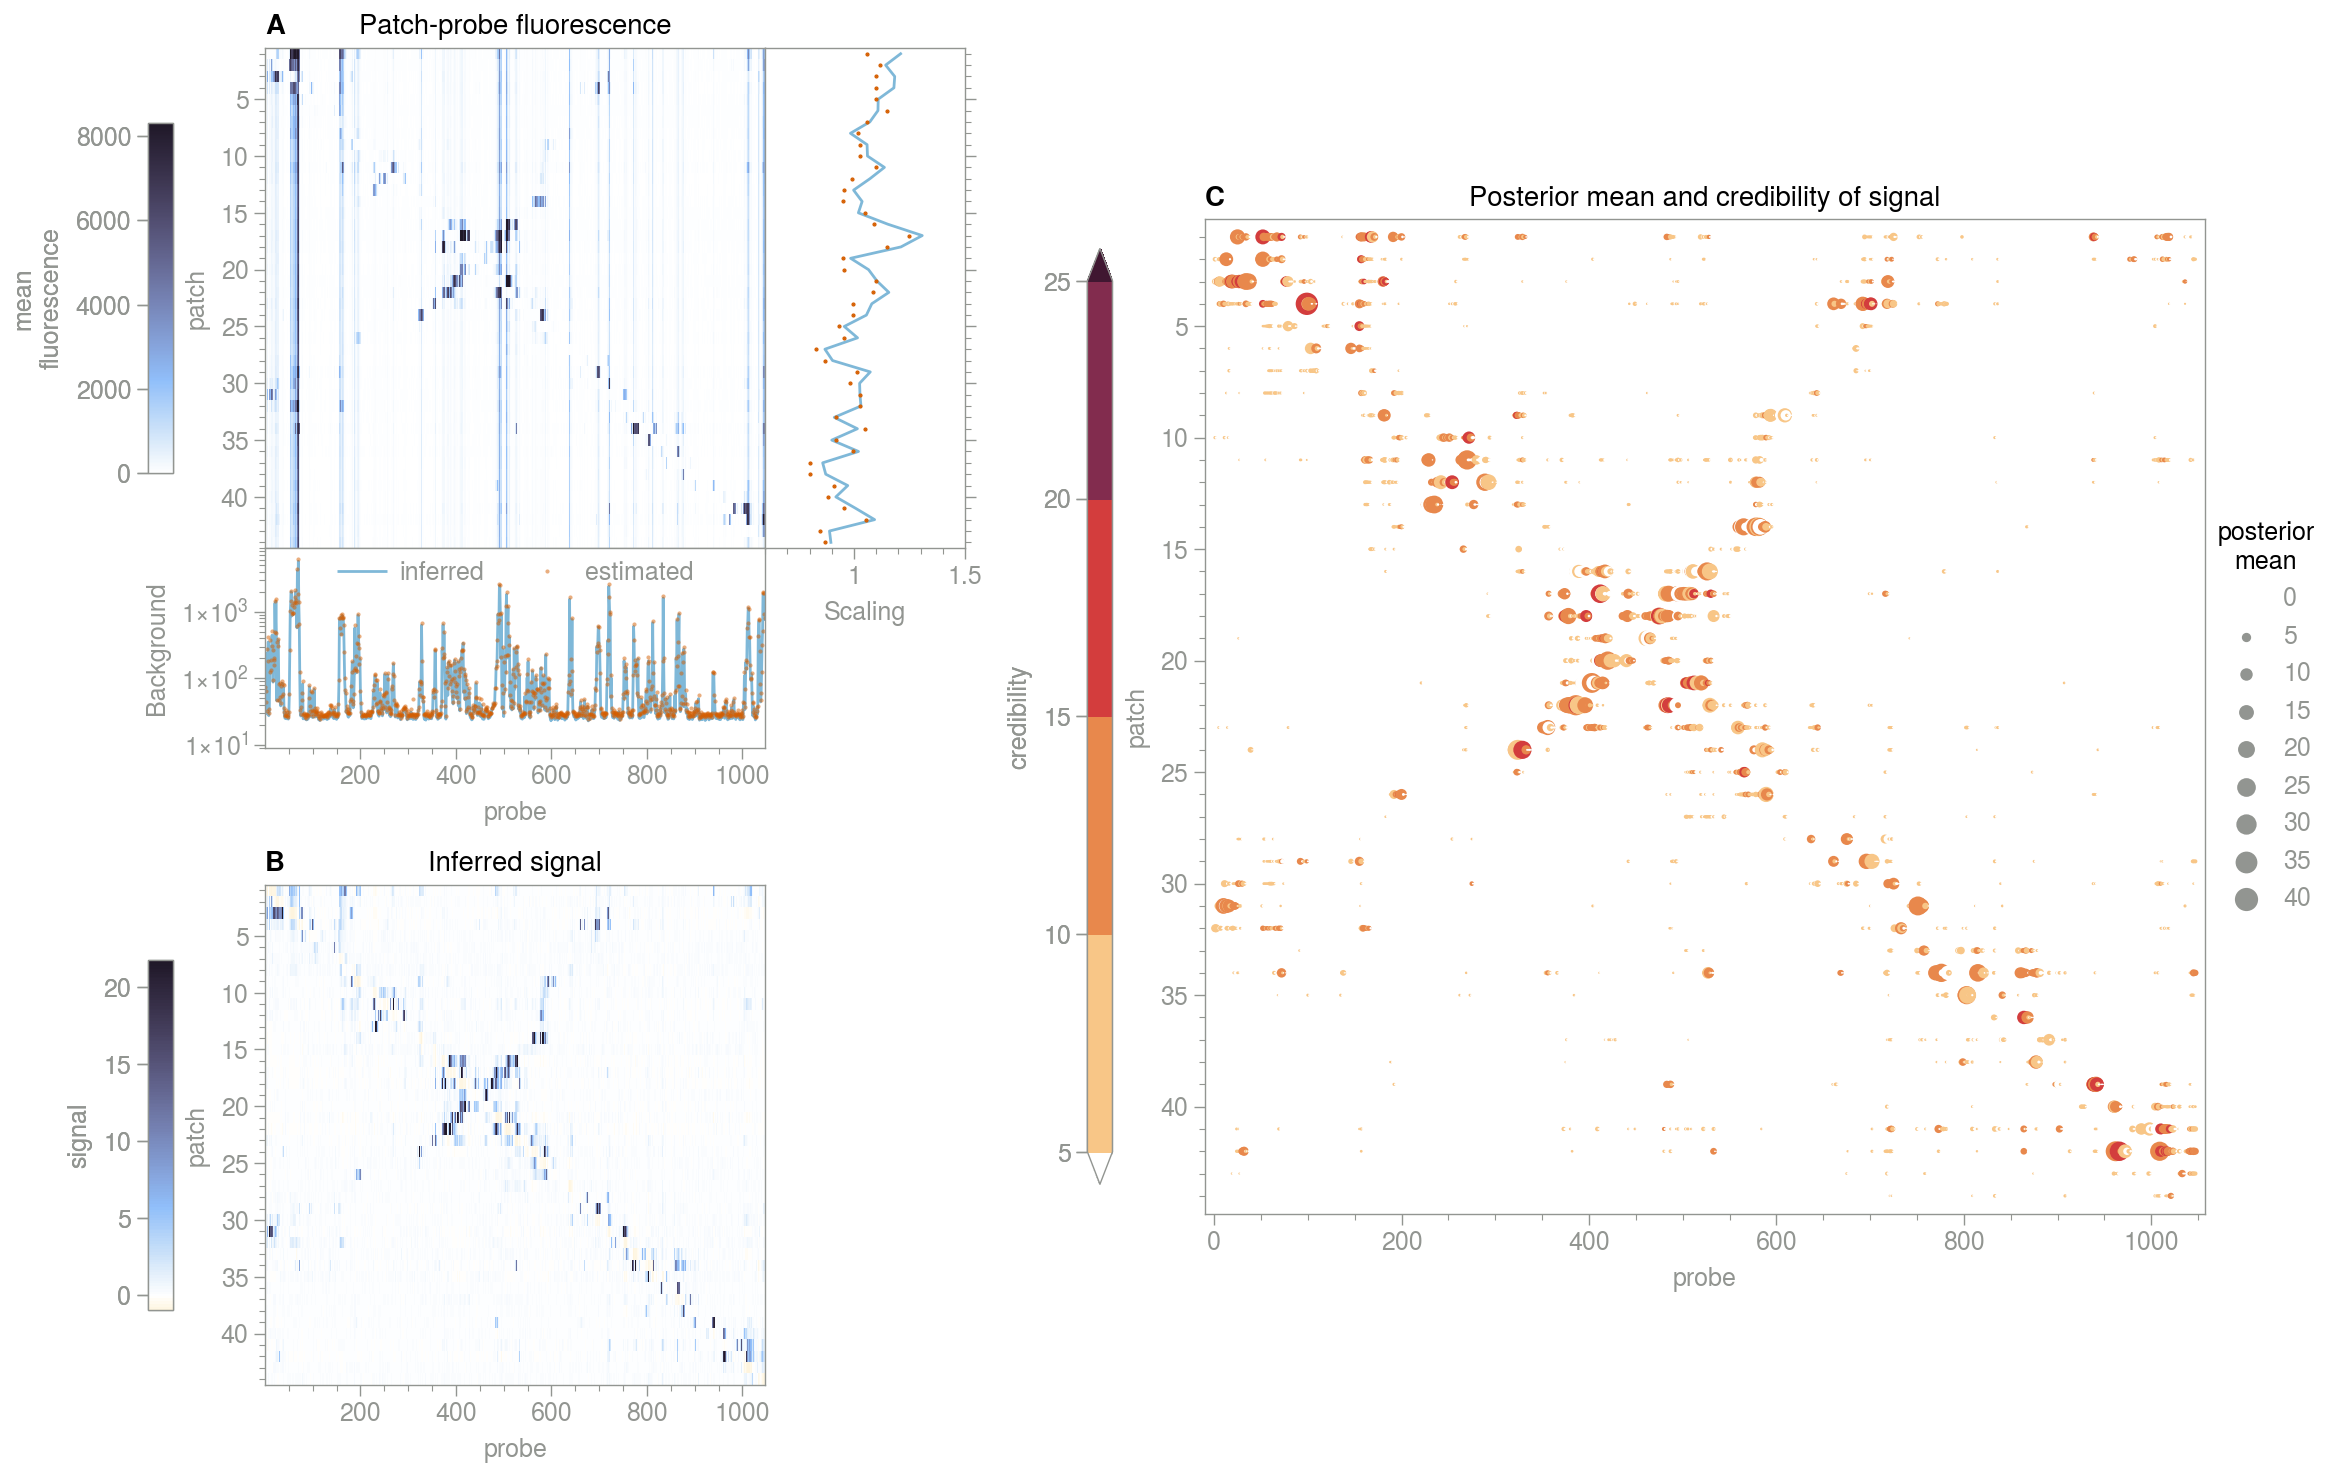

In [23]:
pp.plot_signal_posterior(summary_stats);

The following lines show the summary statistics of the hyperparameters:

In [24]:
with model:
    display(az.summary(idata, var_names=['sigma', 'mu_c', 'sigma_c', 'nu_obs', 'nu_obs_B'])) 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.119,0.001,0.116,0.121,0.000,0.000,325.0,463.0,1.01
mu_c,1.047,0.017,1.016,1.079,0.002,0.002,48.0,225.0,1.06
sigma_c,0.103,0.013,0.081,0.129,0.001,0.001,146.0,385.0,1.01
nu_obs,3.466,0.113,3.264,3.680,0.006,0.004,357.0,481.0,1.02
nu_obs_B,4.311,0.364,3.654,5.022,0.013,0.009,793.0,654.0,1.00


## Inference of prevalences from all data sets

The following code will run the MCMC sampler on all the datasets, this time using the model for prevalences (in the code, this is called the `fraction` model).  As with the signal model, if the output file exists this code will load it instead of re-sampling.  To force re-sampling, delete or rename the existing output file.

Note that the sampler may perform poorly on the 24-nt probe data sets.  This occurs because there is only one blocked probe per patch, making it difficult to infer the patch affinities.

In [25]:
for dataset in datasets.values():
    print(dataset.description)
    
    # make model
    model = pp.PatchprobeModel(dataset, background_scale=set_background_scale(dataset), model_type='fraction')
    # sample from it and save results
    _, _ = model.sample(idata_path = idata_path, summary_path = summary_path, **fraction_kwargs)

STMV 12-nt probes
Loading existing inference data file: sdsu12_STMV_12_24_annealed_SG15294487_258644410004_S001_agilent-fraction-idata.nc
Original sampling time was 3:23:17.913944
Loading existing summary file: data/InferenceData/sdsu12_STMV_12_24_annealed_SG15294487_258644410004_S001_agilent-fraction-summary.nc
STMV 24-nt probes
Loading existing inference data file: sdsu24_STMV_24_24_annealed_SG15294487_258644410004_S001_agilent-fraction-idata.nc
Original sampling time was 5:51:52.379238
Loading existing summary file: data/InferenceData/sdsu24_STMV_24_24_annealed_SG15294487_258644410004_S001_agilent-fraction-summary.nc
STMV 12-nt probes; patches not annealed
Loading existing inference data file: sdsu12unannealed_STMV_12_24_unannealed_SG15294487_258644410002_20220920123447_S001_agilent-fraction-idata.nc
Original sampling time was 2:50:04.988810
Loading existing summary file: data/InferenceData/sdsu12unannealed_STMV_12_24_unannealed_SG15294487_258644410002_20220920123447_S001_agilent-fr

## Example of prevalence results from STMV RNA 12-nt probe data set

As above, we can use functions from the `patchprobe` library can be used to find sampling results for a specific data set and plot the results.

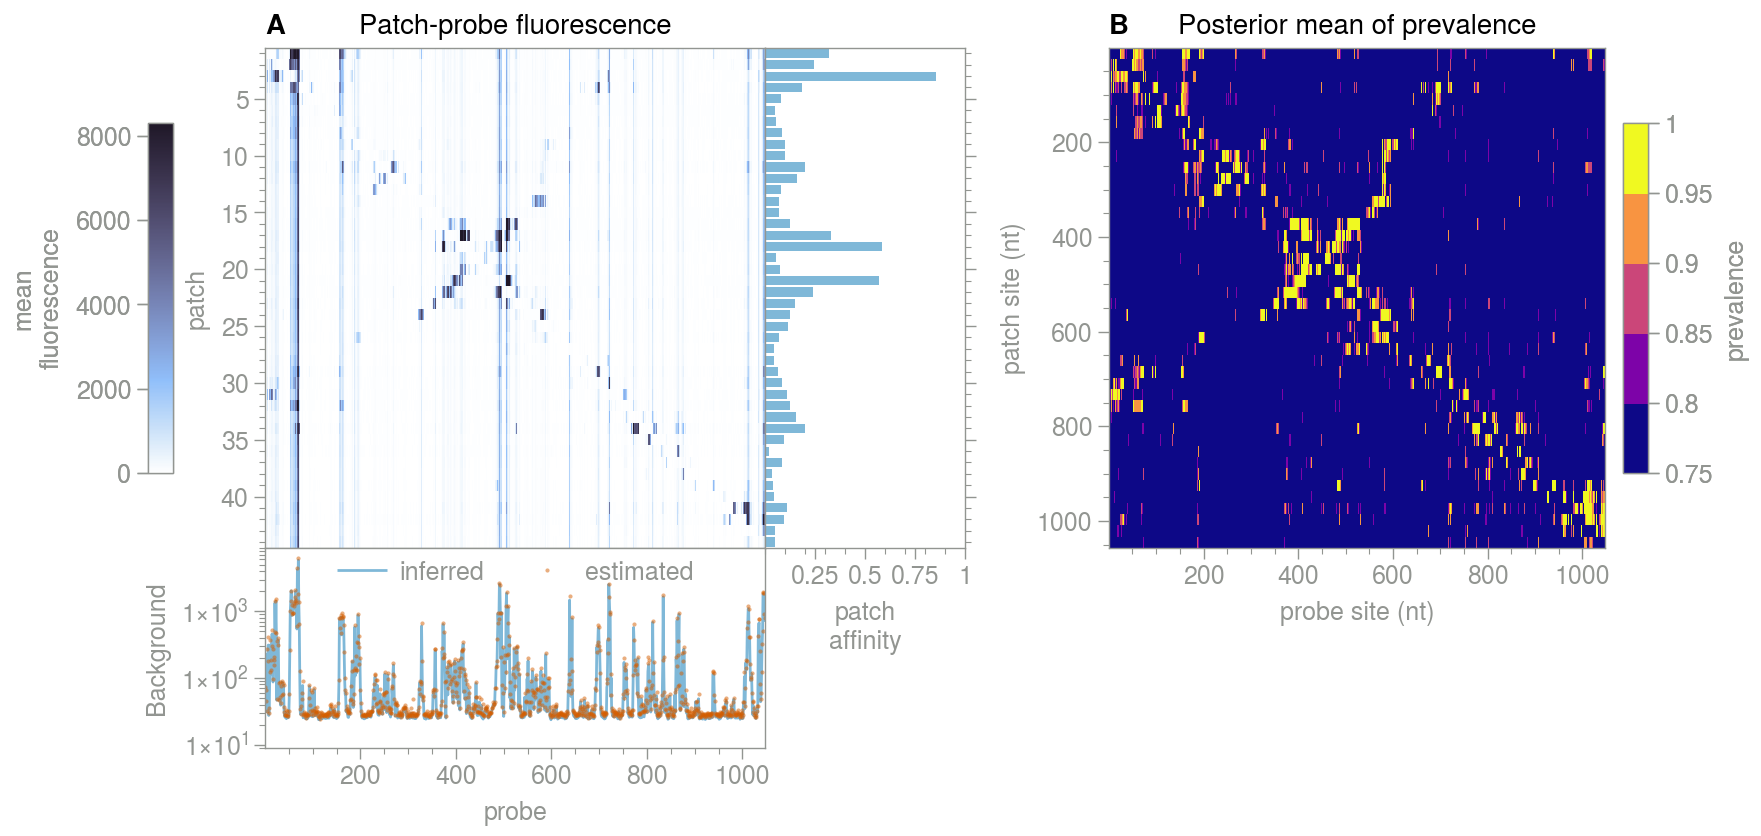

In [26]:
summary_file = pp.find_summaries(datasets['sdsu12'], summary_path, model_type='fraction')
summary_stats = xr.open_dataset(summary_file[0])
pp.plot_prevalence_posterior(summary_stats);

Hyperparameter results:

In [27]:
with model:
    display(summary_stats[['sigma', 'mu_c', 'sigma_c', 'nu_obs', 'nu_obs_B']].to_dataframe().T) 

metric,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.120522,0.000354,0.119856,0.121153,0.000015,0.000010,599.643904,716.484181,1.001863
mu_c,1.018926,0.012192,0.994972,1.039425,0.000363,0.000257,1160.669290,464.473719,1.006070
sigma_c,0.086077,0.009400,0.070147,0.103174,0.000289,0.000216,1227.476428,341.354208,1.010944
nu_obs,3.356309,0.028259,3.302748,3.406002,0.002891,0.002050,97.989339,704.646395,1.032327
nu_obs_B,5.026595,0.148050,4.742992,5.289045,0.004455,0.003160,1096.388559,649.984279,0.999420
